In [402]:
import pandas as pd

cp = pd.read_csv('/Users/user/Documents/DF/train.csv')

In [403]:
drop_col=['model','engine']
cp.drop(drop_col,axis=1,inplace=True)

### fuel_type

In [407]:
# 연료 타입 매핑
fuel_mapping = {
    'E85 Flex Fuel': 'Gasoline',  # E85 Flex Fuel -> Gasoline
    'Plug-In Hybrid': 'Hybrid',  # Plug-In Hybrid -> Hybrid
}

# fuel_type 값 매핑 적용
cp['fuel_type'] = cp['fuel_type'].replace(fuel_mapping)

# 결측치 및 불필요한 데이터 삭제
cp = cp.dropna(subset=['fuel_type'])  # NaN 행 삭제
cp = cp[~cp['fuel_type'].isin(['not supported', '–'])]  # 'not supported'와 '–' 행 삭제

# 결과 확인
print(cp['fuel_type'].value_counts(dropna=False))
print(f"Remaining data: {cp.shape[0]} rows")


fuel_type
Gasoline    171346
Hybrid        7353
Diesel        3955
Name: count, dtype: int64
Remaining data: 182654 rows


In [409]:
cp['fuel_type'].value_counts()

fuel_type
Gasoline    171346
Hybrid        7353
Diesel        3955
Name: count, dtype: int64

### transmission

In [412]:
## Transmission 값 정리
def clean_transmission(value):
    value = value.strip()  # 공백 제거
    # DCT 관련 변환
    if '7-Speed DCT Automatic' in value or 'Transmission w/Dual Shift Mode' in value:
        return 'DCT'  # DCT로 변경
    # CVT 관련 변환
    elif 'CVT Transmission' in value or 'CVT-F' in value or 'Automatic CVT' in value:
        return 'CVT'  # CVT로 변경
    else:
        return value  # 다른 값은 그대로 반환

# transmission 컬럼 값 정리
cp['transmission'] = cp['transmission'].apply(clean_transmission)

# 삭제할 값 목록
values_to_remove = [
    "Transmission Overdrive Switch",
    "2",
    "–",
    "Variable",
    "F",
    "SCHEDULED FOR OR IN PRODUCTION",
    "Single-Speed Fixed Gear",
    "6-Speed",  # 정확히 6-Speed인 행 삭제
    "7-Speed"   # 정확히 7-Speed인 행 삭제
]

# transmission 컬럼에서 해당 값들과 정확히 일치하는 행 삭제
cp = cp[~cp['transmission'].isin(values_to_remove)]

In [414]:
# 특정 패턴을 가진 transmission 값을 변환하는 함수
def replace_transmission(value):
    # '6 speed mt M/T M/T' -> '6-speed a/t'
    if '6 speed' in value.lower() and 'mt' in value.lower() and 'm/t' in value.lower():
        return '6-Speed A/T'

    # '6-speed electronically controlled A/T' -> '6-speed a/t'
    elif '6-speed electronically controlled a/t' in value.lower():
        return '6-Speed A/T'

    # '6 speed at/mt A/T A/T' -> '6-speed a/t'
    elif '6 speed' in value.lower() and 'at' in value.lower() and 'a/t' in value.lower():
        return '6-Speed A/T'

    # '8-speed at A/T A/T' -> '8-speed a/t'
    elif '8-speed' in value.lower() and 'at' in value.lower() and 'a/t' in value.lower():
        return '8-Speed A/T'

    # 조건에 맞지 않으면 원래 값을 반환
    return value

# transmission 컬럼에 대해 변환 적용
cp['transmission'] = cp['transmission'].apply(replace_transmission)

# 결과 확인
print(cp['transmission'].value_counts(dropna=False))
print(f"Remaining data: {cp.shape[0]} rows")


transmission
A/T                                                   46959
8-Speed A/T                                           20562
DCT                                                   19187
6-Speed A/T                                           17999
6-Speed M/T                                           11892
7-Speed A/T                                           11109
Automatic                                             10383
8-Speed Automatic                                      8415
10-Speed A/T                                           8016
9-Speed A/T                                            3852
5-Speed A/T                                            3183
10-Speed Automatic                                     3163
CVT                                                    2818
6-Speed Automatic                                      2796
4-Speed A/T                                            2479
5-Speed M/T                                            2342
9-Speed Automatic          

In [416]:
# transmission 칼럼의 값을 모두 소문자로 변환
cp['transmission'] = cp['transmission'].str.lower()

In [418]:
cp['transmission'].value_counts()

transmission
a/t                                                   46959
8-speed a/t                                           20569
dct                                                   19187
6-speed a/t                                           17999
6-speed m/t                                           11892
7-speed a/t                                           11109
automatic                                             10383
8-speed automatic                                      8415
10-speed a/t                                           8016
9-speed a/t                                            3852
5-speed a/t                                            3183
10-speed automatic                                     3163
cvt                                                    2818
6-speed automatic                                      2796
4-speed a/t                                            2479
5-speed m/t                                            2342
9-speed automatic          

### out col

In [422]:
# 대표 색상 매핑 정의 (수정된 버전)
representative_colors = {
    'Black': [
        'Black', 'Santorini Black Metallic', 'Obsidian Black Metallic', 'Ebony Black', 'Mythos Black',
        'Beluga Black', 'Black Sapphire Metallic', 'Midnight Black', 'Black Raven', 'Black Obsidian',
        'Black Cherry', 'Black Noir Pearl', 'Phantom Black Pearl Effect / Black Roof', 'Crystal Black Pearl',
        'Stellar Black Metallic', 'Aurora Black', 'Jet Black Mica', 'Black Clearcoat', 'DB Black Clearcoat'
    ],
    'White': [
        'White', 'designo Diamond White Metallic', 'Snowflake White Pearl', 'Glacial White Pearl',
        'Fuji White', 'Ultra White', 'White Frost Tri-Coat', 'Platinum White Pearl', 'White Diamond Tri-Coat',
        'Bright White Clearcoat', 'Snow White Pearl Metallic', 'Frozen White'
    ],
    'Gray': [
        'Gray', 'Silver', 'Shadow Gray Metallic', 'Daytona Gray', 'Daytona Gray Pearl Effect',
        'Nebula Gray Pearl', 'Graphite Grey Metallic', 'Magnetic Gray Clearcoat', 'Arctic Gray Metallic',
        'Granite Crystal Clearcoat Metallic', 'Magnetic Metallic'
    ],
    'Silver': [
        'Silver', 'Satin Steel Metallic', 'Brilliant Silver Metallic', 'Atomic Silver',
        'Billet Silver Metallic Clearcoat', 'Silver Radiance', 'Silver Zynith', 'Silver Ice Metallic',
        'Lunar Silver Metallic'
    ],
    'Blue': [
        'Blue', 'Antimatter Blue Metallic', 'Lunar Blue Metallic', 'Deep Blue Metallic',
        'Nautical Blue Pearl', 'Midnight Blue Metallic', 'Pacific Blue Metallic', 'Blu', 'Blueprint',
        'Dark Moon Blue Metallic'
    ],
    'Red': [
        'Red', 'Firecracker Red Clearcoat', 'Velvet Red Pearlcoat', 'Rosso Mars Metallic', 'Matador Red Metallic',
        'Siren Red Tintcoat', 'Barcelona Red', 'Ruby Flare Pearl', 'Soul Red Crystal Metallic',
        'Cajun Red Tintcoat', 'Rosso', 'Delmonico Red Pearlcoat'
    ],
    'Green': [
        'Green', 'Emerald Green Metallic', 'Python Green', 'Lizard Green', 'Dark Moss', 'Firenze Red'
    ],
    'Gold': [
        'Gold', 'Bronze Dune Metallic'
    ],
    'Brown': [
        'Brown', 'Tan', 'Kodiak Brown Metallic', 'Cajun Red Tintcoat', 'Dark Slate Metallic'
    ],
    'Yellow': ['Yellow'],
    'Orange': ['Orange'],
    'Beige': ['Beige'],
    'Purple': ['Purple'],
    'Etc': [
        'C / C', 'Designo Magno Matte'  # 모르는 색상 추가
    ]
}
# 색상 매핑 및 개수 확인
def map_colors(color):
    for rep_color, colors in representative_colors.items():
        if color in colors:
            return rep_color
    return 'Etc'  # 매칭되지 않는 색상은 'Etc'로 반환

cp['ext_col'] = cp['ext_col'].apply(map_colors)
rep_color_counts = cp['ext_col'].value_counts()
print(rep_color_counts)

ext_col
Black     49292
White     44015
Gray      41976
Blue      14495
Etc       11072
Red       10761
Green      2900
Gold       1663
Brown      1257
Silver     1252
Orange     1104
Beige      1065
Yellow      958
Purple      329
Name: count, dtype: int64


In [424]:
cp['ext_col'].value_counts()

ext_col
Black     49292
White     44015
Gray      41976
Blue      14495
Etc       11072
Red       10761
Green      2900
Gold       1663
Brown      1257
Silver     1252
Orange     1104
Beige      1065
Yellow      958
Purple      329
Name: count, dtype: int64

### int col

In [427]:
# 모든 행을 출력할 수 있도록 설정
pd.set_option('display.max_rows', None)

# ext_col의 고유 값과 각 값의 개수 확인
value_counts = cp['int_col'].value_counts()
print(value_counts)

int_col
Black                         104144
Beige                          23972
Gray                           20683
Brown                           5743
Red                             5035
–                               4403
White                           3646
Jet Black                       2386
Ebony                           1789
Orange                           919
Blue                             704
Global Black                     627
Silver                           400
Nero Ade                         370
Gold                             331
Black / Express Red              320
Graphite                         252
Rioja Red                        240
Diesel Gray / Black              223
Black Onyx                       202
Charcoal                         198
Green                            181
Medium Stone                     170
Medium Earth Gray                169
Sandstone                        158
Parchment                        152
Satin Black                   

In [428]:
# 색상 매핑 정의
representative_colors = {
    'Black': ['Black', 'Santorini Black Metallic', 'Obsidian Black Metallic', 'Ebony Black', 'Mythos Black', 'Beluga Black', 'Black Sapphire Metallic', 'Midnight Black', 'Black Raven', 'Black Obsidian', 'Black Cherry', 'Black Noir Pearl', 'Phantom Black Pearl Effect / Black Roof', 'Crystal Black Pearl', 'Stellar Black Metallic', 'Aurora Black'],
    'White': ['White', 'designo Diamond White Metallic', 'Snowflake White Pearl', 'Glacial White Pearl', 'Fuji White', 'Ultra White', 'White Frost Tri-Coat', 'Platinum White Pearl', 'White Diamond Tri-Coat'],
    'Gray': ['Gray', 'Silver', 'Shadow Gray Metallic', 'Daytona Gray', 'Daytona Gray Pearl Effect', 'Nebula Gray Pearl', 'Graphite Grey Metallic', 'Magnetic Gray Clearcoat', 'Arctic Gray Metallic'],
    'Silver': ['Silver', 'Satin Steel Metallic', 'Brilliant Silver Metallic', 'Atomic Silver', 'Billet Silver Metallic Clearcoat', 'Silver Radiance', 'Silver Zynith'],
    'Blue': ['Blue', 'Antimatter Blue Metallic', 'Lunar Blue Metallic', 'Deep Blue Metallic', 'Nautical Blue Pearl', 'Midnight Blue Metallic', 'Pacific Blue Metallic'],
    'Red': ['Red', 'Firecracker Red Clearcoat', 'Velvet Red Pearlcoat', 'Rosso Mars Metallic', 'Matador Red Metallic', 'Siren Red Tintcoat', 'Barcelona Red', 'Ruby Flare Pearl'],
    'Green': ['Green', 'Emerald Green Metallic', 'Python Green', 'Lizard Green'],
    'Gold': ['Gold', 'Bronze Dune Metallic'],
    'Brown': ['Brown', 'Tan', 'Kodiak Brown Metallic'],
    'Yellow': ['Yellow'],
    'Orange': ['Orange'],
    'Beige': ['Beige'],
    'Purple': ['Purple'],
    'Etc': []  # 모르는 색상을 여기로 분류
}

# '/'가 있는 경우, 첫 번째 색상을 기준으로 분류하는 함수
def map_to_representative_color(color):
    primary_color = color.split('/')[0].strip()  # '/' 기준으로 앞쪽 색상 추출
    for rep_color, color_list in representative_colors.items():
        if any(primary_color in c for c in color_list):
            return rep_color
    return 'Etc'  # 매핑되지 않은 색상은 'Etc'로 분류

# 데이터프레임 컬럼에 매핑 적용
cp['int_col'] = cp['int_col'].apply(map_to_representative_color)



In [430]:
cp['int_col'].value_counts()

int_col
Black     106764
Beige      23972
Gray       21335
Etc        13114
Brown       5950
Red         5083
White       3735
Orange       919
Blue         704
Gold         331
Green        181
Yellow        51
Name: count, dtype: int64

### model year, accident, clean_title

In [434]:
cp["model_year"] = 2024 - cp["model_year"]


In [436]:
cp['accident'].fillna('None reported', inplace=True)

/var/folders/yj/y3b7nzyn7zv0l9bkqtj_37g40000gn/T/ipykernel_6972/1409608088.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cp['accident'].fillna('None reported', inplace=True)


In [438]:
cp['clean_title'].fillna('Unknown', inplace=True)

/var/folders/yj/y3b7nzyn7zv0l9bkqtj_37g40000gn/T/ipykernel_6972/3055727686.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cp['clean_title'].fillna('Unknown', inplace=True)


In [440]:
# cp를 'processed_cp.csv'로 저장
# cp.to_csv('processed_cp.csv', index=False, encoding='utf-8-sig')

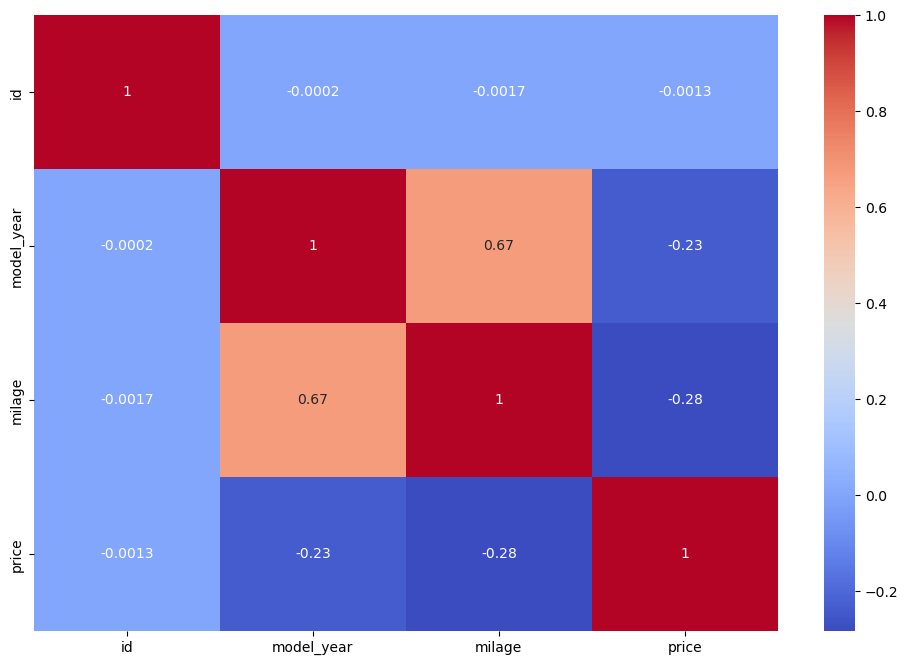

In [442]:
cp_numeric = cp.select_dtypes(include=[float, int])

# 상관계수 행렬 계산
correlation_matrix = cp_numeric.corr()

# 히트맵 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## 인코딩

In [445]:
# 원핫인코딩할 열 지정
columns_to_encode = ['brand', 'fuel_type', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']

# 원핫인코딩 수행
cp_encoded = pd.get_dummies(cp, columns=columns_to_encode, drop_first=True)


In [447]:
# 원핫인코딩된 브랜드별 데이터 확인
brand_columns = [col for col in cp_encoded.columns if 'brand_' in col]

# 각 브랜드에 대한 빈도 확인
for col in brand_columns:
    print(f"{col}: {cp_encoded[col].sum()}")  # 각 브랜드별로 해당하는 데이터 수

brand_Alfa: 679
brand_Aston: 235
brand_Audi: 10756
brand_BMW: 16953
brand_Bentley: 1148
brand_Bugatti: 7
brand_Buick: 938
brand_Cadillac: 4634
brand_Chevrolet: 16135
brand_Chrysler: 693
brand_Dodge: 2918
brand_FIAT: 42
brand_Ferrari: 356
brand_Ford: 22532
brand_GMC: 3184
brand_Genesis: 966
brand_Honda: 2081
brand_Hummer: 518
brand_Hyundai: 2008
brand_INFINITI: 3247
brand_Jaguar: 1304
brand_Jeep: 6448
brand_Karma: 5
brand_Kia: 2442
brand_Lamborghini: 785
brand_Land: 9514
brand_Lexus: 8601
brand_Lincoln: 2419
brand_Lotus: 51
brand_Lucid: 17
brand_MINI: 1059
brand_Maserati: 936
brand_Maybach: 2
brand_Mazda: 2655
brand_McLaren: 242
brand_Mercedes-Benz: 19084
brand_Mercury: 50
brand_Mitsubishi: 549
brand_Nissan: 3825
brand_Plymouth: 7
brand_Polestar: 2
brand_Pontiac: 533
brand_Porsche: 10305
brand_RAM: 4239
brand_Rivian: 91
brand_Rolls-Royce: 556
brand_Saab: 22
brand_Saturn: 147
brand_Scion: 120
brand_Subaru: 2378
brand_Suzuki: 8
brand_Tesla: 375
brand_Toyota: 8750
brand_Volkswagen: 1735
br

In [449]:
# 럭셔리 브랜드 병합 (예시)
cp_encoded['luxury_brand'] = (
    cp_encoded['brand_Bentley'] +
    cp_encoded['brand_Rolls-Royce'] +
    cp_encoded['brand_Lamborghini'] +
    cp_encoded['brand_Ferrari']
).apply(lambda x: 1 if x > 0 else 0)

# 병합 후 개별 브랜드 열 제거
cp_encoded = cp_encoded.drop(columns=['brand_Bentley', 'brand_Rolls-Royce', 'brand_Lamborghini', 'brand_Ferrari'])

print("럭셔리 브랜드 병합 후 데이터 크기:", cp_encoded.shape)


럭셔리 브랜드 병합 후 데이터 크기: (182139, 123)


In [451]:
# IQR을 사용하여 이상치 탐지 및 제거
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 이상치 제거
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_clean

# 주행거리 및 연식에서 이상치 제거
cp_x_clean = remove_outliers(cp_encoded, 'milage')
cp_x_clean = remove_outliers(cp_x_clean, 'model_year')

print("이상치 제거 후 데이터 크기:", cp_x_clean.shape)

이상치 제거 후 데이터 크기: (175999, 123)


In [453]:
cp_x_clean.head()

,id,model_year,milage,price,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bugatti,brand_Buick,...,int_col_Gold,int_col_Gray,int_col_Green,int_col_Orange,int_col_Red,int_col_White,int_col_Yellow,accident_None reported,clean_title_Yes,luxury_brand
3,3,7,19500,45000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
4,4,3,7388,97500,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
5,5,6,40950,29950,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,True,0
6,6,8,62200,28500,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,True,0
7,7,8,102604,12500,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,True,0


In [455]:
cp_y = cp_x_clean['price']
cp_x_clean = cp_x_clean.drop(['id','price'],axis=1)

In [457]:
cp_x_clean.head()

,model_year,milage,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bugatti,brand_Buick,brand_Cadillac,brand_Chevrolet,...,int_col_Gold,int_col_Gray,int_col_Green,int_col_Orange,int_col_Red,int_col_White,int_col_Yellow,accident_None reported,clean_title_Yes,luxury_brand
3,7,19500,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
4,3,7388,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
5,6,40950,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
6,8,62200,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,0
7,8,102604,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,False,True,True,0


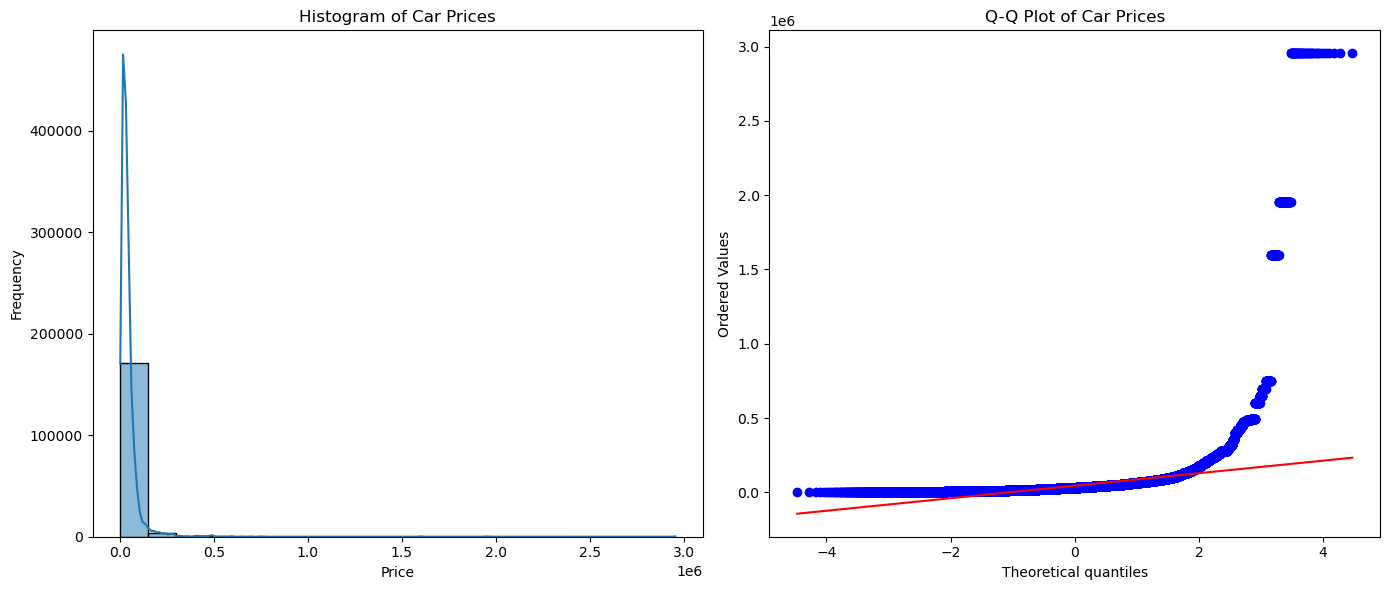

In [459]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# cp_y를 시리즈로 변환 (이 부분은 cp_y가 DataFrame이 아닌 Series일 경우)
cp_y_series = cp_y.squeeze()  # cp_y가 DataFrame이라면 Series로 변환

# 히스토그램 및 Q-Q plot 그리기
plt.figure(figsize=(14, 6))

# 원래 가격 히스토그램
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 subplot
sns.histplot(cp_y_series, bins=20, kde=True)
plt.title('Histogram of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Q-Q plot
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 subplot
stats.probplot(cp_y_series, dist="norm", plot=plt)
plt.title('Q-Q Plot of Car Prices')

plt.tight_layout()
plt.show()

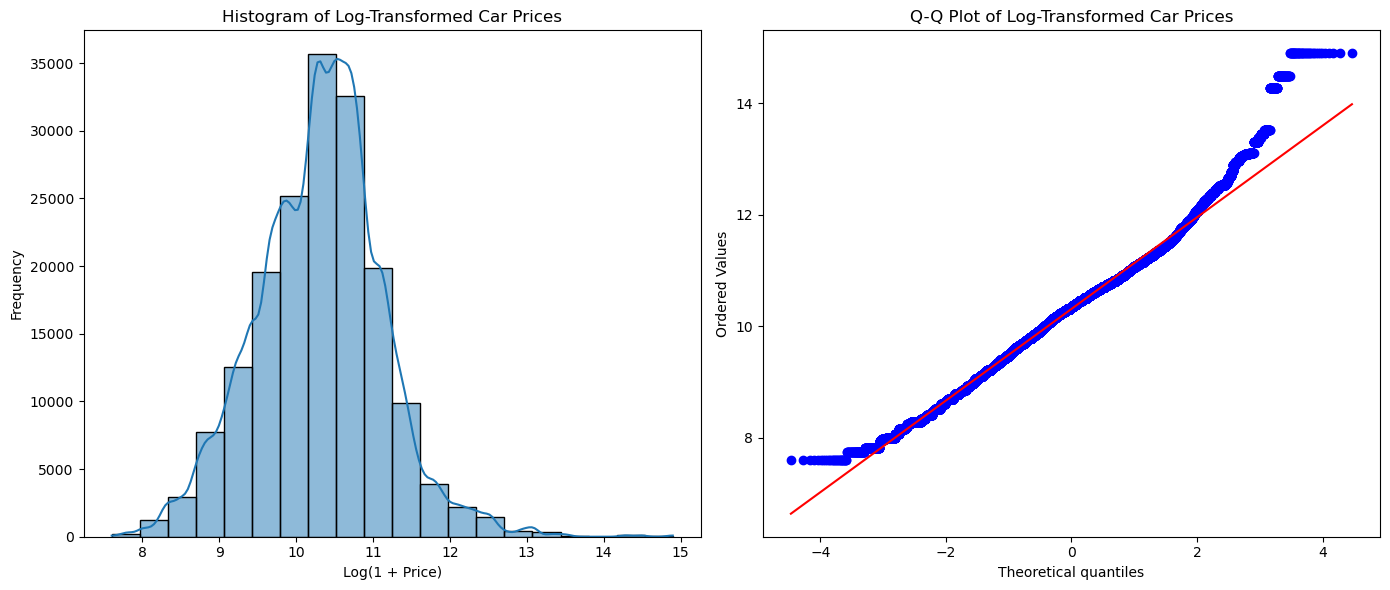

In [460]:
# 로그 변환 (log(1 + x) 형태로 변환)
cp_y_log = np.log1p(cp_y_series)

# 로그 변환된 가격 히스토그램
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 subplot
sns.histplot(cp_y_log, bins=20, kde=True)
plt.title('Histogram of Log-Transformed Car Prices')
plt.xlabel('Log(1 + Price)')
plt.ylabel('Frequency')

# 로그 변환된 데이터 Q-Q plot
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 subplot
stats.probplot(cp_y_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Car Prices')

plt.tight_layout()
plt.show()

In [462]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cp_x_clean[['milage', 'model_year']] = scaler.fit_transform(cp_x_clean[['milage', 'model_year']])

In [463]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(cp_x_clean, cp_y_log, test_size=0.2, random_state=42)

# 선형 회귀 모델 적합
model = LinearRegression()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 로그 변환을 푼 후 예측 값 복원
y_pred_log = model.predict(X_test)
y_pred2 = np.exp(y_pred_log)  # 로그 변환 푼 값 (지수 변환)

# 실제 값도 원래 값으로
y_test2 = np.exp(y_test)

# 새로운 RMSE 계산 방식 사용
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

rmse2 = root_mean_squared_error(y_test2, y_pred2)
print(f"RMSE2: {rmse2}")

RMSE: 0.5194056638168891
RMSE2: 73765.48106487222
